# RBF Network - Corrected
By Edison Gu

We first set up the enviornment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Function to be approximated
def my_function(x):
    return (0.5 + 0.4 * np.sin(2 * np.pi * x))

Construct the features and target values for this regression problem:

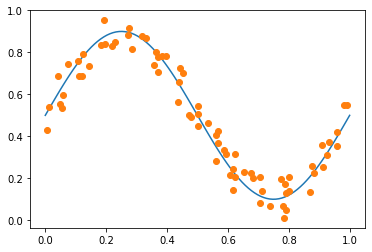

In [3]:
# Seed the random generator
np.random.seed(1234)

# Construct inputs by sampling from uniform dist
feature = np.random.sample(75)

# Calculate ground-truth target
ground_truth = my_function(feature)

# Add uniform noise to the target
target = ground_truth + np.random.sample(75) / 5 - 0.1

true_x = np.linspace(0, 1, 100)
true_y = my_function(true_x)
plt.plot(true_x, true_y)
plt.plot(feature, target, 'o')
plt.show()

We then build our K-mean algorithm:

In [4]:
def K_mean(feature, k):

    # Initialize K centers
    center = np.random.choice(feature, size=k, replace=False)
    width = np.array([])

    while True:

        # Assign each x to its closest center
        label = np.array([])

        for f in feature:

            min_distance = None
            nearest_label = None

            for i in range(k):

                c = center[i]
                distance = np.linalg.norm(f - c)

                if min_distance is None or distance < min_distance:  # Short circuit
                    min_distance = distance
                    nearest_label = i

            label = np.append(label, nearest_label)

        # Calculate the mean of each cluster
        cluster_mean = np.array([])

        for i in range(k):
            cluster_mean = np.append(cluster_mean, feature[label == i].mean())

        # Continue updating the cluster centers if any x is reassigned to a new center
        if np.array_equal(cluster_mean, center):

            # Calculate the width of each cluster
            one_sample_pos = np.array([], dtype=int)
            for i in range(k):

                # If a cluster contains only one sample point...
                if sum(label == i) == 1:
                    one_sample_pos = np.append(one_sample_pos, i)
                else:
                    width = np.append(width, np.linalg.norm(
                        center[i] - feature[label == i]).mean())

            # ... we set its variance the mean variance of all the other clusters
            if one_sample_pos.size != 0:

                mean_variance = width.mean()

                for pos in one_sample_pos:
                    width = np.insert(width, pos, mean_variance)

            break

        else:
            center = cluster_mean

    return center, width, label

Define our RBF kernal:

In [5]:
def rbf(x, center, width):

    transformed = np.array([])

    for c, w in zip(center, width):

        transformed = np.append(
            transformed, np.exp(- 1 / (2 * (w**2)) * np.linalg.norm(x - c)**2))

    return transformed

Set up some parameters for our specific problem:

In [6]:
epoch = 100
plt.rcParams['figure.figsize'] = (16, 4)

Train our RBF network:

Number of Bases K = 2; Learning Rate = 0.01
Training MSE = 0.036703
--- 0.458501 seconds ---


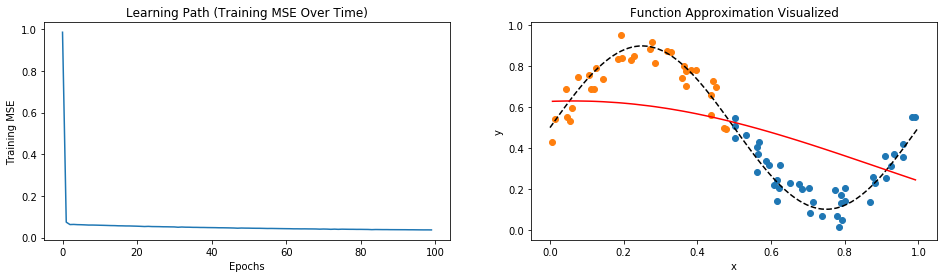


Number of Bases K = 4; Learning Rate = 0.01
Training MSE = 0.017189
--- 0.796298 seconds ---


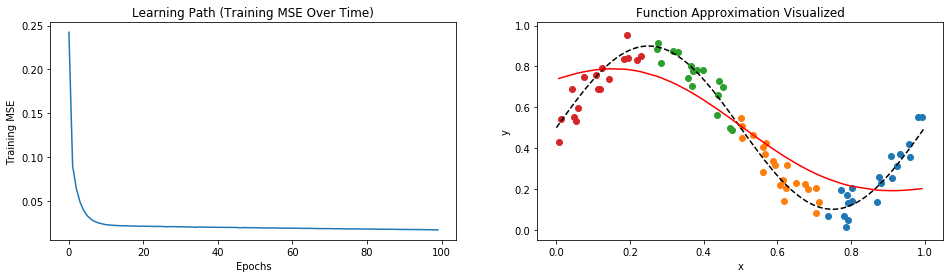


Number of Bases K = 7; Learning Rate = 0.01
Training MSE = 0.004044
--- 1.431767 seconds ---


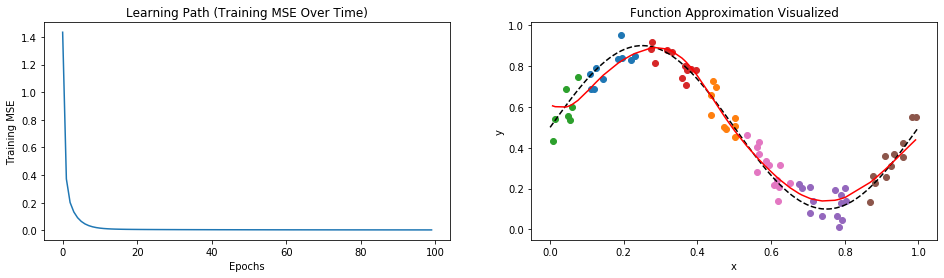


Number of Bases K = 11; Learning Rate = 0.01
Training MSE = 0.005251
--- 2.263152 seconds ---


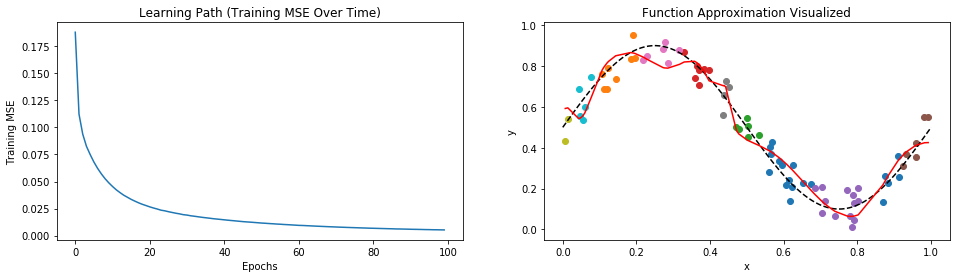


Number of Bases K = 16; Learning Rate = 0.01
Training MSE = 0.005271
--- 2.292441 seconds ---


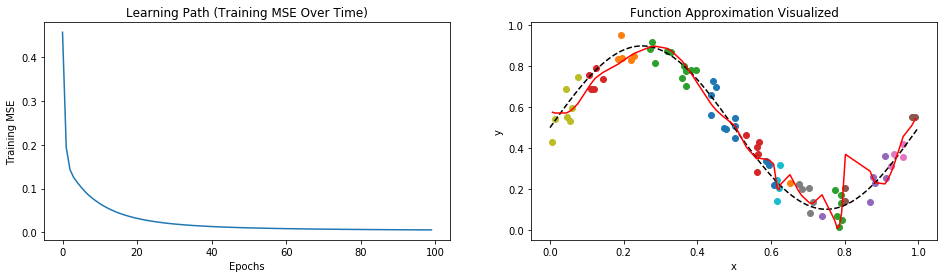


Number of Bases K = 2; Learning Rate = 0.02
Training MSE = 0.030049
--- 0.501333 seconds ---


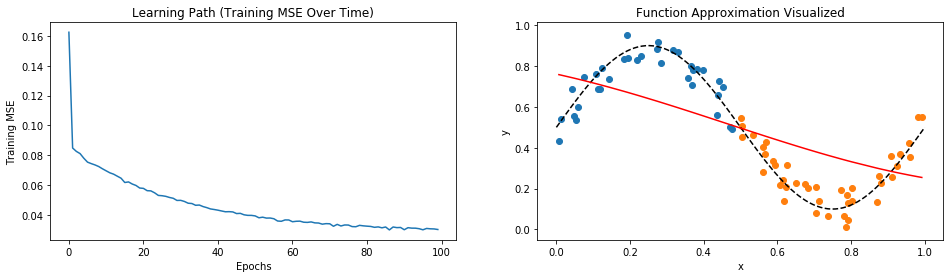


Number of Bases K = 4; Learning Rate = 0.02
Training MSE = 0.005626
--- 0.752070 seconds ---


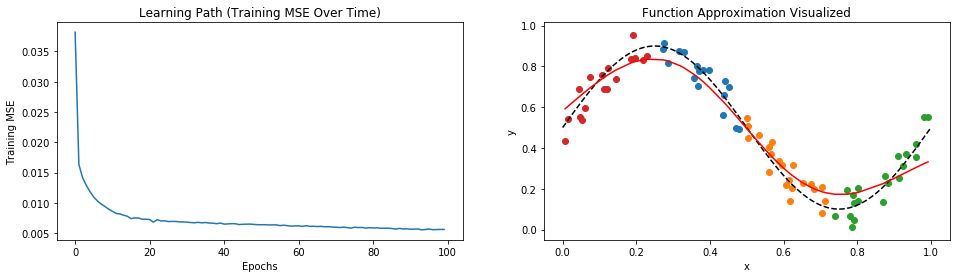


Number of Bases K = 7; Learning Rate = 0.02
Training MSE = 0.003516
--- 1.282876 seconds ---


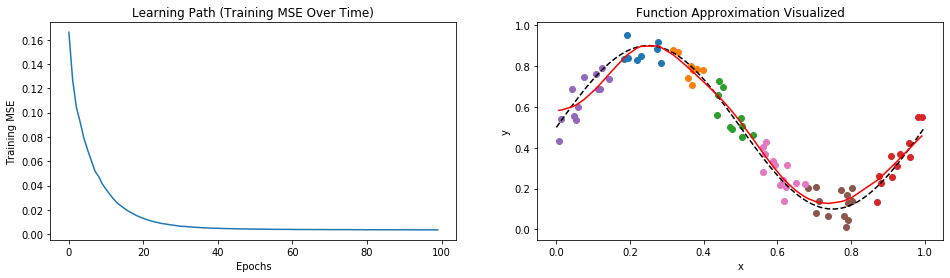


Number of Bases K = 11; Learning Rate = 0.02
Training MSE = 0.003449
--- 1.693600 seconds ---


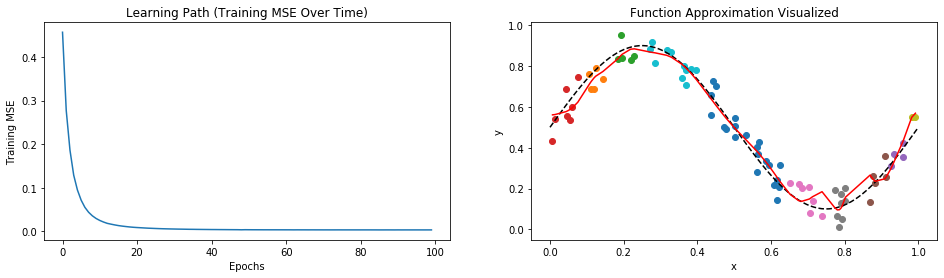


Number of Bases K = 16; Learning Rate = 0.02
Training MSE = 0.005484
--- 2.153200 seconds ---


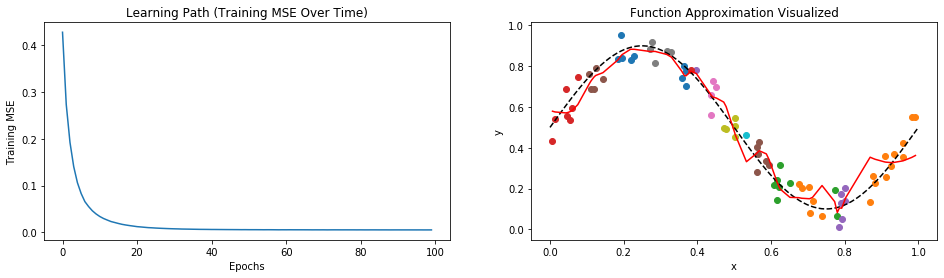

In [7]:
for learn_rate in (0.01, 0.02):
    for k in (2, 4, 7, 11, 16):

        start_time = time.time()
        print(f'Number of Bases K = {k}; Learning Rate = {learn_rate:.2f}')

        # Run K-mean clustering
        center, width, label = K_mean(feature, k)

        # Initialize weights
        weight = np.random.uniform(low=-1, high=1, size=k+1)
        
        history = []

        # Train `epoch` epochs
        for e in range(epoch):

            epoch_size = len(feature)
            order = np.random.choice(
                range(epoch_size), size=epoch_size, replace=False)

            # Pass one observation through the network
            sse = 0
            for i in order:
                x = feature[i]

                # Transform x into feature space using RBF
                transformed = rbf(x, center, width)
                transformed = np.append(transformed, 1)  # Add a bias term
                
                # Compute y and gradient
                y = np.matmul(weight, transformed)
                grad = (y - target[i]) * transformed

                # Update weight
                weight -= learn_rate * grad

                # Log error
                error = np.matmul(weight, transformed) - target[i]
                sse += error**2

            mse = sse / epoch_size
            history.append(mse)

        print(f'Training MSE = {history[-1]:.6f}')
        print(f'--- {(time.time() - start_time):.6f} seconds ---')

        fig, (ax1, ax2) = plt.subplots(1, 2)

        # Plot MSE path over # of epochs
        ax1.plot(history)
        ax1.set(xlabel='Epochs', ylabel='Training MSE')
        ax1.set_title('Learning Path (Training MSE Over Time)')

        # Predicted y
        pred_y = np.array([])
        sorted_feature = np.sort(feature)
        
        for x in sorted_feature:
            transformed = np.append(rbf(x, center, width), 1)
            pred_y = np.append(pred_y, np.matmul(weight, transformed))
        
        # Plot the data points, the original function, and the function generated by the RBF network
        ax2.plot(true_x, true_y, '--k')
        for i in range(k):
            ax2.scatter(feature[label == i], target[label == i], color=f'C{i}')

        ax2.plot(sorted_feature, pred_y, color='red')
        ax2.set(xlabel='x', ylabel='y')
        ax2.set_title('Function Approximation Visualized')

        plt.show()
        print()